# Part 1. Install Packages

In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-po29zee6
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-po29zee6
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 6d9104bb64d3ec8aa39dbe652184f642faff465f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-3m649lqf/elegantrl_8c0f4805e24044febedfc15ebac8cc65
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-3m649lqf/elegantrl_8c0f4805e24044febedfc15ebac8cc65
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 5e828af1503098f4da046c0f12432dbd4ef8bd97
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/

In [2]:
!pip install pandas_market_calendars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.4/198.4 kB 11.9 MB/s eta 0:00:00


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers

import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

check_and_make_directories([TRAINED_MODEL_DIR])

import itertools

# Part 2. Fetch data

[yfinance](https://github.com/ranaroussi/yfinance) is an open-source library that provides APIs fetching historical data form Yahoo Finance.

**OHLCV**: Data downloaded are in the form of OHLCV, corresponding to **open, high, low, close, volume,** respectively. OHLCV is important because they contain most of numerical information of a stock in time series. From OHLCV, traders can get further judgement and prediction like the momentum, people's interest, market trends, etc.

### Using FinRL

In FinRL's YahooDownloader, we modified the data frame to the form that convenient for further data processing process. We use adjusted close price instead of close price, and add a column representing the day of a week (0-4 corresponding to Monday-Friday).

In [ ]:
aapl_df_finrl = YahooDownloader(start_date = '2020-01-01',
                                end_date = '2020-01-31',
                                ticker_list = ['aapl']).fetch_data()

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (20, 8)


In [ ]:
aapl_df_finrl.head()

Price,date,close,high,low,open,volume,tic,day
0,2020-01-02,72.716072,75.150002,73.797501,74.059998,135480400,aapl,3
1,2020-01-03,72.009125,75.144997,74.125000,74.287498,146322800,aapl,4
2,2020-01-06,72.582909,74.989998,73.187500,73.447502,118387200,aapl,0
3,2020-01-07,72.241547,75.224998,74.370003,74.959999,108872000,aapl,1
4,2020-01-08,73.403633,76.110001,74.290001,74.290001,132079200,aapl,2


## Data for the chosen tickers

In [ ]:
config_tickers.DOW_30_TICKER

['AXP',
 'AMGN',
 'AAPL',
 'BA',
 'CAT',
 'CSCO',
 'CVX',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'KO',
 'JPM',
 'MCD',
 'MMM',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'TRV',
 'UNH',
 'CRM',
 'VZ',
 'V',
 'WBA',
 'WMT',
 'DIS',
 'DOW']

In [ ]:
TRAIN_START_DATE = '2020-01-01'
TRAIN_END_DATE = '2021-01-01'
TRADE_START_DATE = '2021-01-01'
TRADE_END_DATE = '2021-06-01'

In [ ]:
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (10650, 8)


In [ ]:
df_raw.head()

Price,date,close,high,low,open,volume,tic,day
0,2020-01-02,72.716080,75.150002,73.797501,74.059998,135480400,AAPL,3
1,2020-01-02,204.452927,243.190002,238.979996,243.000000,2088000,AMGN,3
2,2020-01-02,117.618538,126.269997,124.230003,124.660004,2708000,AXP,3
3,2020-01-02,331.348572,333.350006,327.700012,328.549988,4544400,BA,3
4,2020-01-02,134.388809,150.550003,147.979996,149.000000,3311900,CAT,3


# Part 3: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

Hear let's take **MACD** as an example. Moving average convergence/divergence (MACD) is one of the most commonly used indicator showing bull and bear market. Its calculation is based on EMA (Exponential Moving Average indicator, measuring trend direction over a period of time.)

In [ ]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_raw)

[*********************100%***********************]  1 of 1 completed

Successfully added technical indicators
Shape of DataFrame:  (354, 8)
Successfully added vix


Successfully added turbulence index


In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [ ]:
processed_full.head()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-01-02,AAPL,72.716080,75.150002,73.797501,74.059998,135480400.0,3.0,0.0,73.362388,71.362817,0.0,-66.666667,100.0,72.716080,72.716080,12.47,0.0
1,2020-01-02,AMGN,204.452927,243.190002,238.979996,243.000000,2088000.0,3.0,0.0,73.362388,71.362817,0.0,-66.666667,100.0,204.452927,204.452927,12.47,0.0
2,2020-01-02,AXP,117.618538,126.269997,124.230003,124.660004,2708000.0,3.0,0.0,73.362388,71.362817,0.0,-66.666667,100.0,117.618538,117.618538,12.47,0.0
3,2020-01-02,BA,331.348572,333.350006,327.700012,328.549988,4544400.0,3.0,0.0,73.362388,71.362817,0.0,-66.666667,100.0,331.348572,331.348572,12.47,0.0
4,2020-01-02,CAT,134.388809,150.550003,147.979996,149.000000,3311900.0,3.0,0.0,73.362388,71.362817,0.0,-66.666667,100.0,134.388809,134.388809,12.47,0.0


### Save data to csv file

For Colab users, you can open the virtual directory in colab and manually download the files.

For users running on your local environment, the csv files should be at the same directory of this notebook.

In [ ]:
train.to_csv('train_data.csv')
trade.to_csv('trade_data.csv')

In [ ]:
train = pd.read_csv('train_data.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']

In [5]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 30, State Space: 301


In [6]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [7]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [8]:
agent = DRLAgent(env = env_train)

# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

In [9]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [10]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

-------------------------------------
| time/                 |           |
|    fps                | 219       |
|    iterations         | 100       |
|    time_elapsed       | 2         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -42.5     |
|    explained_variance | 0.0285    |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 3.14      |
|    reward             | 0.2854719 |
|    std                | 0.998     |
|    value_loss         | 0.0753    |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 230        |
|    iterations         | 200        |
|    time_elapsed       | 4          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -42.5      |
|    explained_variance | -0.909     |
|    learning_rate      | 0.0007     |
| 

In [11]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

In [12]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [13]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=10000) if if_using_ddpg else None

day: 252, episode: 200
begin_total_asset: 1000000.00
end_total_asset: 1140151.84
total_reward: 140151.84
total_cost: 14702.20
total_trades: 5399
Sharpe: 0.540
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 31         |
|    time_elapsed    | 31         |
|    total_timesteps | 1012       |
| train/             |            |
|    actor_loss      | -143       |
|    critic_loss     | 2.14e+04   |
|    learning_rate   | 0.001      |
|    n_updates       | 911        |
|    reward          | 0.54301715 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 28         |
|    time_elapsed    | 70         |
|    total_timesteps | 2024       |
| train/             |            |
|    actor_loss      | -51.1      |
|    critic_loss     | 2.32e+03   |
|    learning_rate   | 0.001      |
|    n_update

In [14]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

In [15]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [16]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None

day: 252, episode: 240
begin_total_asset: 1000000.00
end_total_asset: 949581.54
total_reward: -50418.46
total_cost: 42887.70
total_trades: 6804
Sharpe: 0.034
-----------------------------------
| time/              |            |
|    fps             | 303        |
|    iterations      | 1          |
|    time_elapsed    | 6          |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.44508117 |
-----------------------------------
day: 252, episode: 250
begin_total_asset: 1000000.00
end_total_asset: 1022073.71
total_reward: 22073.71
total_cost: 43947.98
total_trades: 6829
Sharpe: 0.248
----------------------------------------
| time/                   |            |
|    fps                  | 267        |
|    iterations           | 2          |
|    time_elapsed         | 15         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01808602 |
|    clip_fraction        | 0.22

In [17]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

In [18]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [19]:
trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=10000) if if_using_td3 else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 36        |
|    time_elapsed    | 27        |
|    total_timesteps | 1012      |
| train/             |           |
|    actor_loss      | -8.26     |
|    critic_loss     | 25.2      |
|    learning_rate   | 0.001     |
|    n_updates       | 911       |
|    reward          | 1.1616701 |
----------------------------------
day: 252, episode: 450
begin_total_asset: 1000000.00
end_total_asset: 1152336.16
total_reward: 152336.16
total_cost: 1682.01
total_trades: 2798
Sharpe: 0.576
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 31        |
|    time_elapsed    | 64        |
|    total_timesteps | 2024      |
| train/             |           |
|    actor_loss      | -2.87     |
|    critic_loss     | 5.86      |
|    learning_rate   | 0.001     |
|    n_updates       | 1923      |
| 

In [20]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

# Time to Backtest

In [22]:
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [23]:
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True

In [24]:
trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

In [25]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 30, State Space: 301


In [26]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [27]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [28]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym) if if_using_a2c else (None, None)

hit end!


In [29]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym) if if_using_ddpg else (None, None)

hit end!


In [30]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym) if if_using_ppo else (None, None)

hit end!


In [31]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment = e_trade_gym) if if_using_td3 else (None, None)

hit end!


In [32]:
df_result_a2c = (
    df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
    if if_using_a2c
    else None
)
df_result_ddpg = (
    df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
    if if_using_ddpg
    else None
)
df_result_ppo = (
    df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
    if if_using_ppo
    else None
)
df_result_td3 = (
    df_account_value_td3.set_index(df_account_value_td3.columns[0])
    if if_using_td3
    else None
)


result = pd.DataFrame(
    {
        "a2c": df_result_a2c["account_value"] if if_using_a2c else None,
        "ddpg": df_result_ddpg["account_value"] if if_using_ddpg else None,
        "ppo": df_result_ppo["account_value"] if if_using_ppo else None,
        "td3": df_result_td3["account_value"] if if_using_td3 else None,
    }
)

In [33]:
result

,a2c,ddpg,ppo,td3
date,,,,
2021-01-04,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
2021-01-05,1.000482e+06,1.001006e+06,1.000116e+06,9.998156e+05
2021-01-06,1.007506e+06,1.007171e+06,1.001571e+06,1.003617e+06
2021-01-07,1.011123e+06,1.011314e+06,1.002447e+06,1.006215e+06
2021-01-08,1.012052e+06,1.010661e+06,1.001978e+06,1.008368e+06
...,...,...,...,...
2021-05-21,1.130269e+06,1.097197e+06,1.154654e+06,1.104034e+06
2021-05-24,1.133526e+06,1.104241e+06,1.163270e+06,1.105319e+06
2021-05-25,1.130744e+06,1.104203e+06,1.160941e+06,1.103415e+06


In [37]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

plt.figure(figsize=(15, 6))
for algo in result.columns:
    plt.plot(result.index, result[algo], label=algo, linewidth=2)

# Formatting the plot
plt.xlabel("Trading Days", fontsize=12)
plt.ylabel("Account Value", fontsize=12)
plt.title("Trading Performance of RL Algorithms", fontsize=14)
plt.legend(loc="upper left")
plt.grid(True, linestyle="--", alpha=0.7)

# Save the plot
plt.savefig("rl_trading_performance.png", dpi=300)
plt.show()


from IPython.display import Image, display

png_file_path = '/content/rl_trading_performance.png'

display(Image(filename=png_file_path))



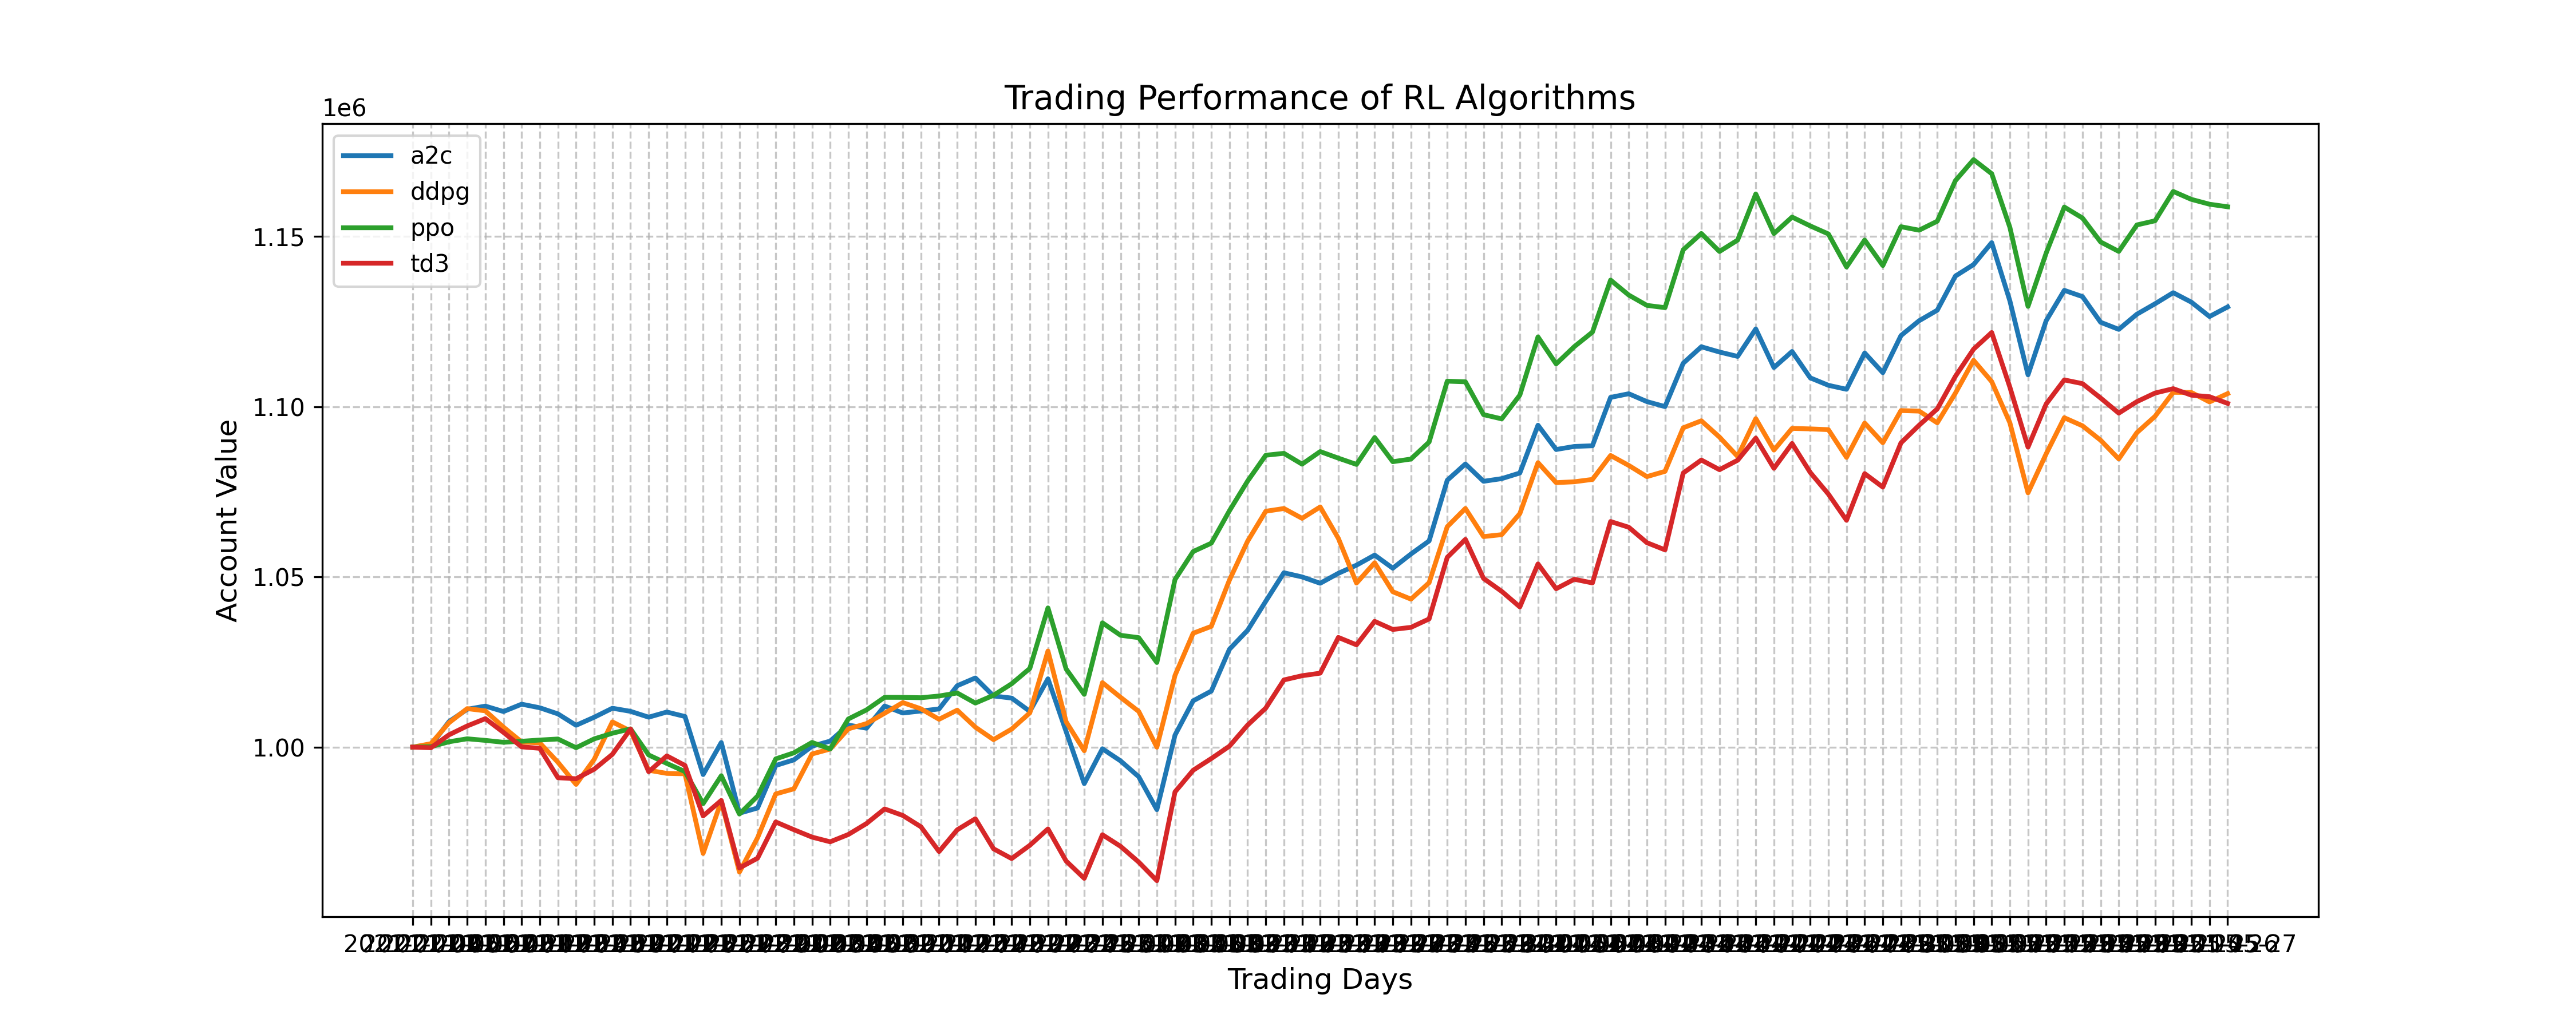